## Hiragana
use CNN to learn and recognize hiraggana

In [35]:
import tensorflow
tensorflow.__version__



'2.7.0'

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

#for CNN model
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D


Import and organize data

In [37]:
## import data
img_test = cv.imread("hiragana-dataset-master/hiragana_images/kanaBA0.jpg", cv.IMREAD_GRAYSCALE)
(img_rows, img_cols) = img_test.shape


In [38]:
## extract the romanji from a filename
import re
# hiragana-dataset-master/hiragana_images/kanaBA0.jpg
def get_romanji(filename):
    keyword = re.search(r'kana(\w+?)\d+', filename).group(1)
    return keyword.lower()


In [39]:
## import data into a list
## construct datatable
import os
import pandas as pd

handwriting_list = []
dir_name = "hiragana-dataset-master/hiragana_images"
# os.listdir(dir_name)
for filename in os.listdir(dir_name):
    # print(f"{dir_name}/f{filename}.jpg")
    picture_label_list = [cv.imread(f"{dir_name}/{filename}", cv.IMREAD_GRAYSCALE), filename, get_romanji(filename)]
    handwriting_list.append(picture_label_list)
# print(handwriting_list)

handwriting_table = pd.DataFrame(handwriting_list, columns=["Handwriting", "Filename", "Romanji"])
handwriting_table

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a
...,...,...,...
995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU5.jpg,yu
996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU6.jpg,yu
997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU7.jpg,yu
998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU8.jpg,yu


In [40]:
## add labels to the datatable w.r.t. the romanji
def romanji_to_dict(S): # construct dict from Romanji series
    romanji_list = list(set(S))
    romanji_dict = {}
    for i, romanji in enumerate(romanji_list):
        romanji_dict[romanji] = i
    return romanji_dict

romanji_dict = romanji_to_dict(handwriting_table["Romanji"])
romanji_categories = len(romanji_dict)
handwriting_table["Label"] = handwriting_table["Romanji"].map(lambda x: romanji_dict[x])
handwriting_table

,Handwriting,Filename,Romanji,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a,4
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a,4
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a,4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a,4
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a,4
...,...,...,...,...
995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU5.jpg,yu,15
996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU6.jpg,yu,15
997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU7.jpg,yu,15
998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU8.jpg,yu,15


In [41]:
## construct X and y data from data-table
X = handwriting_table["Handwriting"].to_numpy()
y = handwriting_table["Label"].to_numpy()
# X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = np.array([X[i].reshape(img_rows, img_cols) for i in range(X.shape[0])])
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X.shape

(1000, 84, 83, 1)

In [42]:
## split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #shuffle=True
Y_train = np_utils.to_categorical(y_train, romanji_categories)
Y_test = np_utils.to_categorical(y_test, romanji_categories)
X_train.shape

(800, 84, 83, 1)

# Standardization
standardize the strength of each pixel from 0-255 to 0-1

In [43]:
## standardize X_train and X_test
def std_X(X):
    X = X.astype('float32') / 255
    return X

X_train = std_X(X_train)
X_test = std_X(X_test)

# CNN Model
construct a CNN model

In [44]:
input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',padding='same',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.125))
model.add(Dense(romanji_categories, activation='softmax'))

print('model.summary:')
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 84, 83, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 83, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 41, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 42, 41, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 110208)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               14106752  
                                       

# Augmentation
Use the augmentation to generate more data from the training data.
Use rotate, height transform, width transform to simulate all kinds of handwritings

In [45]:
from keras.preprocessing.image import ImageDataGenerator

# Range for picking a value from.
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2)


# i = 0
# for batch in datagen.flow(X_train, batch_size=1):
#     plt.subplot(6,5,1 + i)
#     plt.axis("off")
    
#     augImage = batch[0]
#     augImage = augImage.astype('float32')
#     augImage /= 255
#     plt.imshow(augImage)
    
#     i += 1
#     if i > 29:
#         break

In [46]:
## train the model wuth data (including augmentaion datagen)
batch_size = 256  #128
nb_epoch = 26

# generate data with datagen
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
train_history = model.fit(datagen.flow(X_train, Y_train, batch_size=32, subset='training'),
         validation_data=datagen.flow(X_train, Y_train, batch_size=8, subset='validation'),
         batch_size=batch_size, epochs=nb_epoch, verbose=1,
         callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode="auto"))


Epoch 1/26
20/20 [==============================] - 14s 669ms/step - loss: 3.3211 - accuracy: 0.1734 - val_loss: 2.3449 - val_accuracy: 0.3688
Epoch 2/26
20/20 [==============================] - 13s 652ms/step - loss: 1.7035 - accuracy: 0.5703 - val_loss: 1.4853 - val_accuracy: 0.5750
Epoch 3/26
20/20 [==============================] - 14s 706ms/step - loss: 1.1749 - accuracy: 0.6828 - val_loss: 1.1217 - val_accuracy: 0.6875
Epoch 4/26
20/20 [==============================] - 13s 661ms/step - loss: 0.7638 - accuracy: 0.7891 - val_loss: 0.8209 - val_accuracy: 0.8062
Epoch 5/26
20/20 [==============================] - 13s 637ms/step - loss: 0.6822 - accuracy: 0.8125 - val_loss: 0.7429 - val_accuracy: 0.8188
Epoch 6/26
20/20 [==============================] - 13s 638ms/step - loss: 0.5105 - accuracy: 0.8609 - val_loss: 0.9533 - val_accuracy: 0.7437
Epoch 7/26
20/20 [==============================] - 12s 589ms/step - loss: 0.3978 - accuracy: 0.8984 - val_loss: 0.6710 - val_accuracy: 0.8188

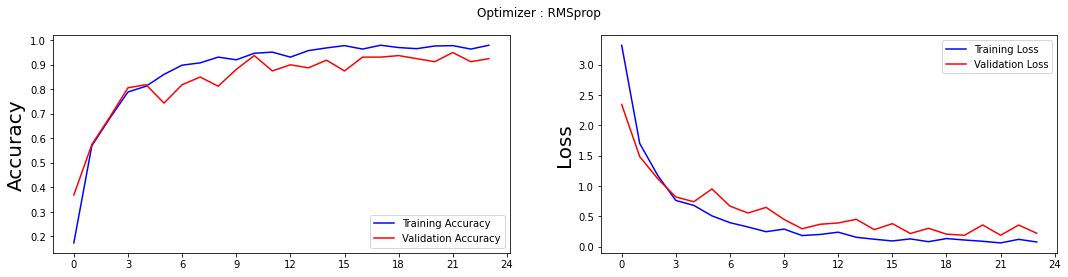

In [47]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(18,4))
ax1 = plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : RMSprop', fontsize=12)
plt.ylabel('Accuracy', fontsize=20)
plt.plot(train_history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(train_history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='lower right')

ax2 = plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=20)
plt.plot(train_history.history['loss'], color='b', label='Training Loss')
plt.plot(train_history.history['val_loss'], color='r', label='Validation Loss')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='upper right')
plt.show()

# Model Evaluation
evaluate the model with test data

In [48]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 1s 63ms/step - loss: 0.0502 - accuracy: 0.9800
Test score: 0.05018329992890358
Test accuracy: 0.9800000190734863


{0: 'fu', 1: 'wo', 2: 'ru', 3: 'ta', 4: 'a', 5: 'ro', 6: 'no', 7: 'to', 8: 'mi', 9: 'sa', 10: 'ma', 11: 'shi', 12: 're', 13: 'ne', 14: 'ke', 15: 'yu', 16: 'i', 17: 'ji', 18: 'ri', 19: 'ko', 20: 'yo', 21: 'chi', 22: 'ni', 23: 'te', 24: 'ra', 25: 'ba', 26: 'so', 27: 'ki', 28: 'ha', 29: 'se', 30: 'wa', 31: 'n', 32: 'mo', 33: 'hi', 34: 'da', 35: 'me', 36: 'ka', 37: 'tsu', 38: 'e', 39: 'su', 40: 'ho', 41: 'nu', 42: 'mu', 43: 'ya', 44: 'pi', 45: 'ku', 46: 'na', 47: 'o', 48: 'he', 49: 'u'}
200
[48 19 11 36 36 25 45 36  5  7 34 28 42 16 44 37 39 22 46 44 37 11 31 42
 43 17 23 30  4 38 33 10 40 47 24 22 11 27  9  1 19 29 35  9 28 19 19 45
 16 17 22 49 33  1 43 25 33 22 41  8 46 40 11 42 41  8 28 13 15 48 11  7
 30 11 30 29 20  3 44 44 39 19 18 24  2 30  3 16 42  1 41 29 41 29 31 12
 14 22 21 47 15 22 32 48 29 43 40 32 38 27 24  5 44  9  4 39  6  9 49 47
 25  5 18 15  4 19 23 46 21  8 23 40 48 40 48 13  8  8  6  5 35 39 33 18
 25  2 14 37 46 31 35 30 37 14 47 15 27 29 48 43 45 48 39  9 47  1 43 

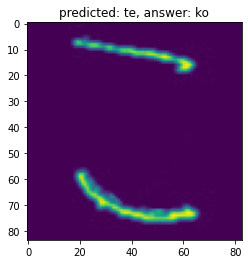

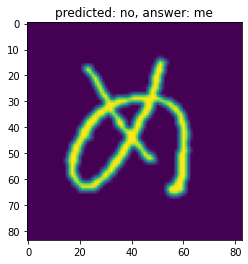

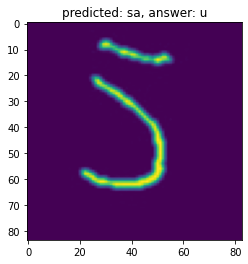

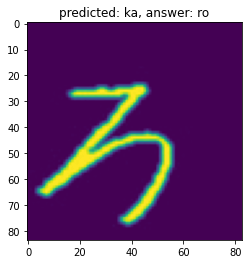

In [49]:
inv_romanji_dict = dict((v,k) for k,v in romanji_dict.items())

print(inv_romanji_dict)

nVal = X_test.shape[0]
print(nVal)
prob = model.predict(X_test)
# print(prob)
predictions=np.argmax(prob,axis=1)

## print the first 20 test samples
num_eachrow = 4
'''
num_test = 20
for i in range(num_test):
    ax = plt.subplot(num_test//num_eachrow, num_eachrow, i+1)
    plt.title(inv_romanji_dict[predictions[i]])
    plt.imshow(X_test[i])
plt.show()
'''

print(predictions)
ground_truth = y_test
print(ground_truth)

## print errors
errors = np.where(predictions != ground_truth)[0]
print(errors)
print("Number of errors = {}/{}".format(len(errors),nVal))
for error in errors:
    plt.title(f"predicted: {inv_romanji_dict[predictions[error]]}, answer: {inv_romanji_dict[y_test[error]]}")
    plt.imshow(X_test[error])
    plt.show()

## Confusion matrix


In [50]:
confusion_matrix = np.zeros((romanji_categories, romanji_categories), dtype=np.uint8)
# confusion_matrix[0][0]
for predict, answer in zip(predictions, ground_truth):
    confusion_matrix[answer][predict] += 1
confusion_matrix


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 0, 0],
       [0, 0, 0, ..., 0, 7, 0],
       [0, 0, 0, ..., 0, 0, 3]], dtype=uint8)

In [52]:
# inv_romanji_dict

In [53]:
import itertools
# import matplotlib.axis as axis
import matplotlib

def geterr_confusion_matrix():
    pass

def plot_confusion_matrix(M, categories, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues, figsize=(20,20)):
    ## normalize option
    if normalize:
        M = M.astype('float') / M.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(M)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(M, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    tick_marks = np.arange(categories)
    tick_labels = [inv_romanji_dict[i] for i in tick_marks]

    ax.xaxis.set_ticks(tick_marks) # rotation=45
    ax.xaxis.set_ticklabels(tick_labels)
    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(tick_labels)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.xaxis.set_label_position('top')

    # fmt = '{:.2f}' if normalize else '{:d}'
    thresh = M.max() / 2.
    for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
        value = M[i,j]
        if not normalize:
            value_str = "{:d}".format(value)
        else:
            if value == 0:
                value_str = "0"
            else:
                value_str = "{:.2f}".format(value)
        ax.text(j, i, value_str,
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if M[i, j] > thresh else "black")




Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 3]]


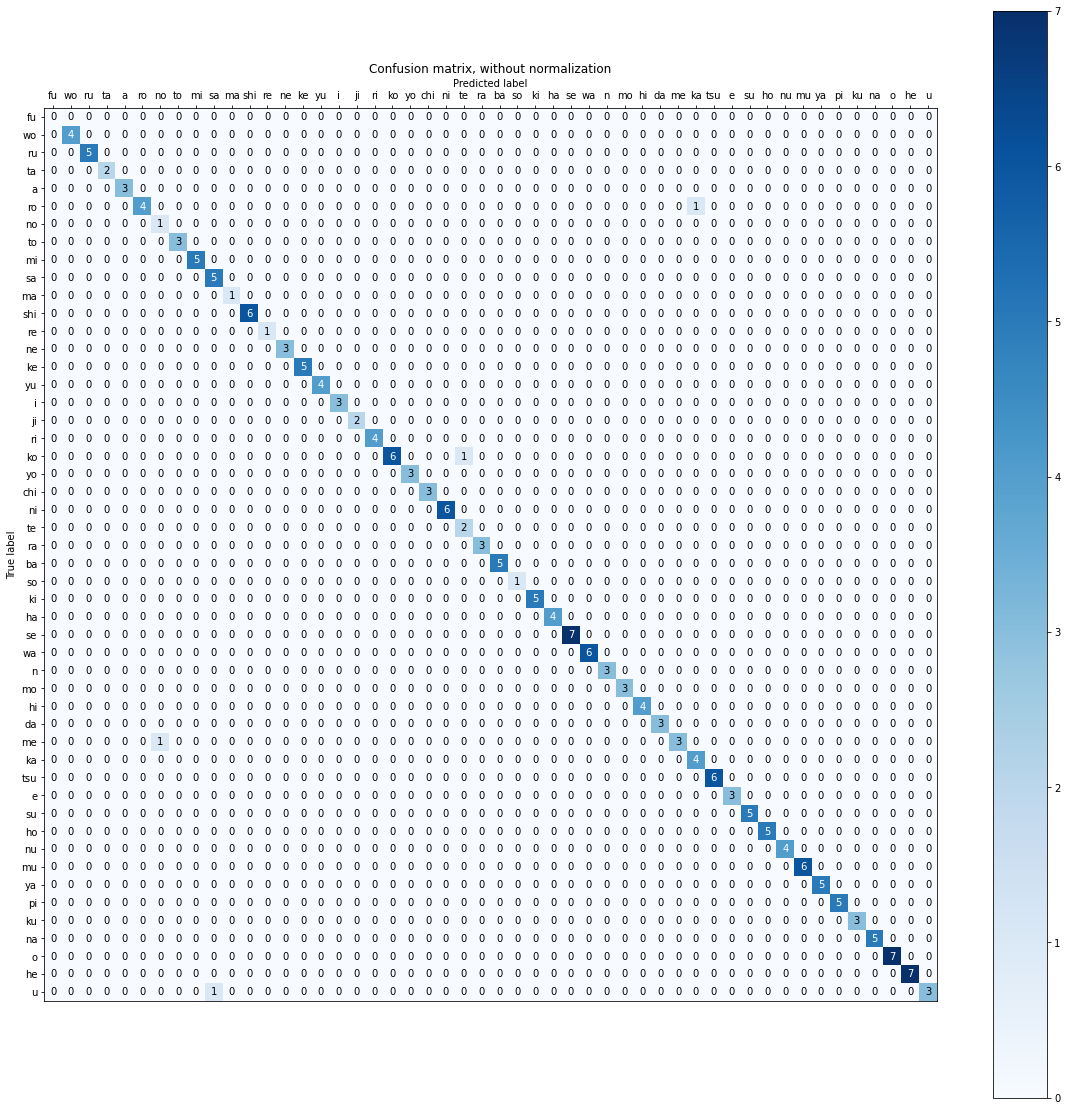

In [54]:

plot_confusion_matrix(confusion_matrix, romanji_categories,
                      title='Confusion matrix, without normalization')



<ipython-input-53-1fee4e15bf22>:11: RuntimeWarning: invalid value encountered in true_divide
  M = M.astype('float') / M.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix
[[ nan  nan  nan ...  nan  nan  nan]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.   1.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.   0.   0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.75]]


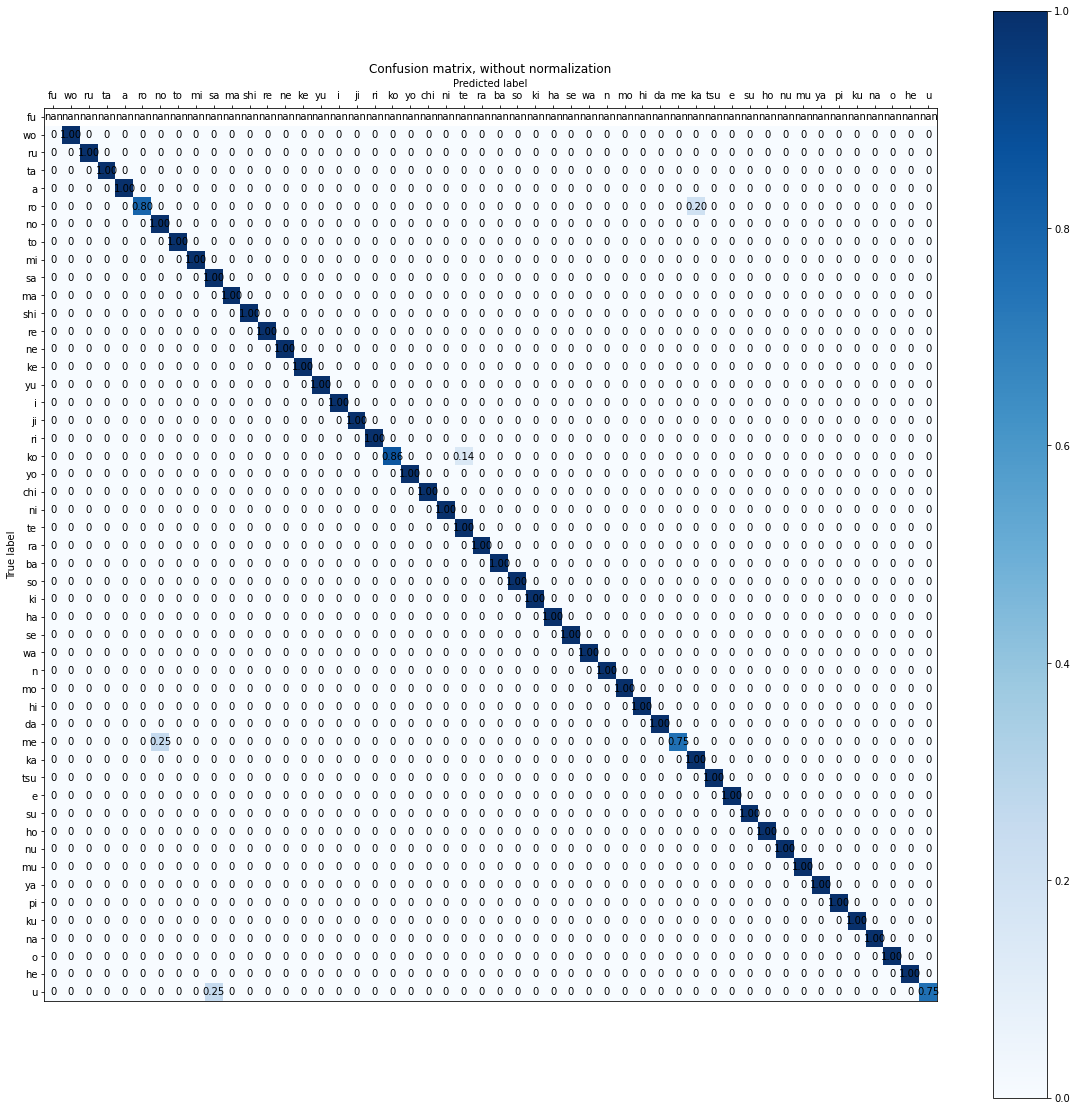

In [55]:
plot_confusion_matrix(confusion_matrix, romanji_categories,
                      normalize=True,
                      title='Confusion matrix, without normalization')

In [56]:
# from keras.models import load_model
# # creates a HDF5 file
# model.save('model_hiragana_recognition_cnn.h5') 
